## Encoder-decoder architecture

![img](https://esciencegroup.files.wordpress.com/2016/03/seq2seq.jpg)


Encoder-decoder architectures are about converting anything to anything, including
 * Machine translation and spoken dialogue systems
 * [Image captioning](http://mscoco.org/dataset/#captions-challenge2015) and [image2latex](https://openai.com/requests-for-research/#im2latex) (convolutional encoder, recurrent decoder)
 * Generating [images by captions](https://arxiv.org/abs/1511.02793) (recurrent encoder, convolutional decoder)
 * Grapheme2phoneme - convert words to transcripts

## Our task: machine translation

We gonna try our encoder-decoder models on russian to english machine translation problem. More specifically, we'll translate hotel and hostel descriptions. 

- Data will be tokenized with WordPunctTokenizer.
- Our data lines contain unique rare words. If we operate on a word level, we will have to deal with large vocabulary size. If instead we use character-level models, it would take lots of iterations to process a sequence.
- One popular approach is called [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt) aka __BPE__. The algorithm starts with a character-level tokenization and then iteratively merges most frequent pairs for N iterations. This results in frequent words being merged into a single token and rare words split into syllables or even characters.



In [1]:
%%capture
!pip3 install torch>=1.3.0
!pip3 install subword-nmt &> log
!wget https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1 -O data.txt
!wget https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/week04_seq2seq/vocab.py -O vocab.py
# thanks to tilda and deephack teams for the data, Dmitry Emelyanenko for the code :)

In [2]:
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F


In [2]:
!head -n 5 data.txt

Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.	Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.
At Tupirmarka Lodge you will find a 24-hour front desk, room service, and a snack bar.	В числе удобств лоджа Tupirmarka круглосуточная стойка регистрации и снэк-бар. Гости могут воспользоваться услугой доставки еды и напитков в номер.
Featuring free WiFi in all areas, Naigao Xiaowo offers accommodation in Shanghai.	Апартаменты Naigao Xiaowo расположены в городе Шанхай. К услугам гостей бесплатный Wi-Fi во всех зонах.
Each has a TV and a private bathroom with shower.	В вашем распоряжении также телевизор и собственная ванная комната с душем.
Your room comes with air conditioning and satellite TV.	Номер оснащен кондиционером и спутниковым телевидением.


### Tokenizing & applying BPE rules

In [3]:
tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

# split and tokenize the data
with open('train.en', 'w') as f_src,  open('train.ru', 'w') as f_dst:
    for line in open('data.txt'):
        src_line, dst_line = line.strip().split('\t')
        f_src.write(tokenize(src_line) + '\n')
        f_dst.write(tokenize(dst_line) + '\n')

In [4]:
# build and apply bpe vocs
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=8000)  # 1. learn_bpe rules
    bpe[lang] = BPE(open('./bpe_rules.' + lang))  # 2. create instance of BPE class
    
    with open('train.bpe.' + lang, 'w') as f_out:
        for line in open('train.' + lang):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')  # 3. apply BPE tokenization to our data

100%|██████████| 8000/8000 [00:10<00:00, 756.04it/s]


In [1]:
# first 3 lines of our BPE tokenized English data:
!head -n 3 /content/train.bpe.en 

cor@@ del@@ ia hotel is situated in tbilisi , a 3 - minute walk away from saint trinity church .
at tu@@ pi@@ r@@ mar@@ ka lodge you will find a 24 - hour front desk , room service , and a snack bar .
featuring free wifi in all areas , nai@@ g@@ ao xiao@@ wo offers accommodation in shanghai .


In [9]:
# first 3 lines of our BPE tokenized Russian data:
!head -n 3 /content/train.bpe.ru 

отель cor@@ del@@ ia расположен в тбилиси , в 3 минутах ходьбы от свя@@ то - тро@@ и@@ ц@@ кого собора .
в числе удобств лоджа tu@@ p@@ ir@@ mar@@ ka круглосуточная стойка регистрации и снэк - бар . гости могут воспользоваться услугой доставки еды и напитков в номер .
апартаменты na@@ i@@ ga@@ o xi@@ a@@ ow@@ o расположены в городе шан@@ хай . к услугам гостей бесплатный wi - fi во всех зонах .


### Building vocabularies

We now need to build vocabularies that map strings to token ids and vice versa.   
We're gonna need these fellas when we feed training data into model or convert output matrices into words.

In [5]:
data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
data_out = np.array(open('./train.bpe.en').read().split('\n'))

train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)
for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: на территории обустроена бесплатная частная парковка .
out: free private parking is available on site .

inp: кроме того , в 5 минутах ходьбы работают многочисленные бары и рестораны .
out: guests can find many bars and restaurants within a 5 - minute walk .

inp: отель san mi@@ gu@@ el расположен в центре мор@@ ели@@ и , в 750 метрах от главной площади города и кафедрального собора .
out: hotel san miguel is located in central more@@ lia , 750 metres from the city ’ s main square and cathedral .



In [6]:
from vocab import Vocab

inp_voc = Vocab.from_lines(train_inp) # creates an instance of Vocab class from input lines (ru (input) vocab here)
out_voc = Vocab.from_lines(train_out) # en (output) vocab

print(f'Length of input (Russian) BPE vocabulary = {len(inp_voc)}')
print(f'Length of output (English) BPE vocabulary = {len(out_voc)}')

Length of input (Russian) BPE vocabulary = 8048
Length of output (English) BPE vocabulary = 7801


In [7]:
# Here's how you cast lines into ids and backwards.

batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']

words to ids (0 = bos, 1 = eos):
tensor([[   0, 2688, 2943, 1108,   29,    1,    1,    1],
        [   0, 2922, 1834, 8035,   59, 3800,   29,    1],
        [   0, 6030, 2083,   29,    1,    1,    1,    1],
        [   0, 4927, 1870,   29,    1,    1,    1,    1],
        [   0, 5549, 1453,   27,  592,   29,    1,    1]])

back to words
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']


Draw source and translation length distributions to estimate the scope of the task.

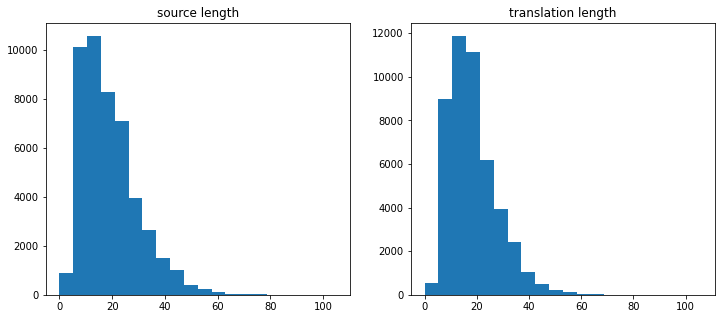

In [8]:
plt.figure(figsize=[12, 5])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(map(len, map(str.split, train_inp))), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(map(len, map(str.split, train_out))), bins=20);

### Encoder-decoder model

The code below contains a simple encoder-decoder model: single GRU encoder/decoder, no attention or anything.

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
from models import BasicModel

model = BasicModel(inp_voc, out_voc).to(device)

# debugging area

dummy_inp_tokens = inp_voc.to_matrix(train_inp[:5]).to(device)
dummy_out_tokens = out_voc.to_matrix(train_out[:5]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))

assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

### Training loss
Our training objective is almost the same as it was for neural language models:
$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

where $|D|$ is the __total length of all sequences__, including BOS and first EOS, but excluding PAD.

In [10]:
from utils import compute_loss

In [11]:
dummy_loss = compute_loss(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.item(), 8.5, rtol=0.1, atol=0.1), "We're sorry for your loss"

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

Loss: tensor(8.4834, device='cuda:0', grad_fn=<NegBackward0>)


### Evaluation: BLEU

Machine translation is commonly evaluated with [BLEU](https://en.wikipedia.org/wiki/BLEU) score. This metric simply computes which fraction of predicted n-grams is actually present in the reference translation. It does so for n=1,2,3 and 4 and computes the geometric average with penalty if translation is shorter than reference.

While BLEU [has many drawbacks](http://www.cs.jhu.edu/~ccb/publications/re-evaluating-the-role-of-bleu-in-mt-research.pdf), it still remains the most commonly used metric and one of the simplest to compute.

In [12]:
from utils import compute_bleu

In [13]:
%time compute_bleu(model, dev_inp, dev_out, device=device)

CPU times: user 13.5 s, sys: 27.2 ms, total: 13.5 s
Wall time: 13.5 s


0.0032785941985881534

In [21]:
# result after training 20k epochs
%time compute_bleu(model, dev_inp, dev_out, beam_size=1, device=device)

CPU times: user 13 s, sys: 235 ms, total: 13.2 s
Wall time: 13.2 s


18.134936985228343

### Training loop

Training encoder-decoder models isn't that different from any other models: sample batches, compute loss, backprop and update

In [15]:
from IPython.display import clear_output
from tqdm import tqdm, trange
from utils import save_checkpoint, load_checkpoint

model = BasicModel(inp_voc, out_voc).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

In [16]:
def train_loop(model, optimizer, train_inp, num_epochs=25000, from_checkpoint=False):   

    metrics = {'train_loss': [], 'dev_bleu': [] }

    if from_checkpoint:
        best_checkpoint = torch.load('/content/best_bleu_state.pth')
        model.load_state_dict(best_checkpoint["state_dict"])
        best_bleu = best_checkpoint['bleu']
    else:
        best_bleu = 0

    for epoch in trange(num_epochs):
        batch_ix = np.random.randint(len(train_inp), size=batch_size)
        batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
        batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)
        
        optimizer.zero_grad() # set the gradients to zero before backpropagation
        loss_t = compute_loss(model, batch_inp, batch_out)
        loss_t.backward()
        optimizer.step()

        
        metrics['train_loss'].append((epoch+1, loss_t.item()))
        
        if (epoch+1) % 100 == 0:
            bleu = compute_bleu(model, dev_inp, dev_out, device=device)
            metrics['dev_bleu'].append((epoch+1, bleu))
            
            if bleu > best_bleu:
                best_bleu = bleu
                checkpoint = {
                    'state_dict' : deepcopy(model.state_dict()), 
                    'optimizer' : deepcopy(optimizer.state_dict()),
                    'epoch' : epoch+1,
                    'bleu' : bleu,
                }
                save_checkpoint(checkpoint, filename="best_bleu_state.pth")

            clear_output(True)
            plt.figure(figsize=(12,4))
            for i, (name, history) in enumerate(sorted(metrics.items())):
                plt.subplot(1, len(metrics), i + 1)
                plt.title(name)
                plt.plot(*zip(*history))
                plt.grid()
            plt.show()
            print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)
    
    return metrics

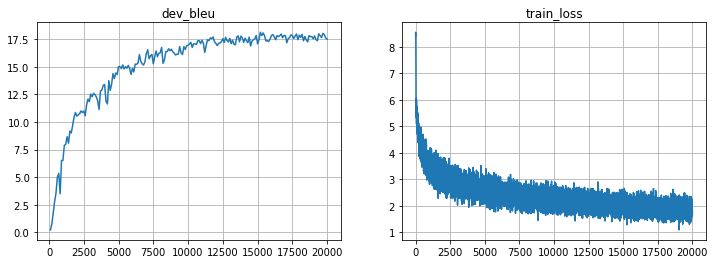

Mean loss=1.853


100%|██████████| 20000/20000 [28:01<00:00, 11.89it/s]


In [17]:
metrics = train_loop(
    model,
    optimizer, 
    train_inp, 
    num_epochs=20000,
    from_checkpoint=False
)

In [18]:
best_checkpoint = torch.load('/content/best_bleu_state.pth')
print('best BLEU = ', best_checkpoint['bleu'])
print('best epoch = ', best_checkpoint['epoch'])

print('Mean BLEU on last 10 epoches = ', np.mean(metrics['dev_bleu'][-10:], axis=0)[1]) # Simple GRU model without attention

best BLEU =  18.134936985228343
best epoch =  15200
Mean BLEU on last 10 epoches =  17.71800153053416


### Beam research

In [19]:
# Return to best checkpoint

print("=> Loading checkpoint")
model.load_state_dict(best_checkpoint["state_dict"])
optimizer.load_state_dict(best_checkpoint["optimizer"])

=> Loading checkpoint


In [20]:
def beam_research(model, inp, out, model_name, beam_min=1, beam_max=10):
    """BLEU scores of a model with different beam_size"""
    
    beam_range = range(beam_min, beam_max + 1)
    blue_scores = []

    for beam_size in beam_range:
        blue = compute_bleu(model, inp, out, beam_size=beam_size, device=device)
        blue_scores.append(blue)

    plt.figure(figsize=(12, 5))
    plt.plot(beam_range, blue_scores)
    plt.title('Beam search results for %s' % model_name)
    plt.xticks(beam_range)
    plt.xlabel('beam size')
    plt.ylabel('BLEU score')
    plt.show()

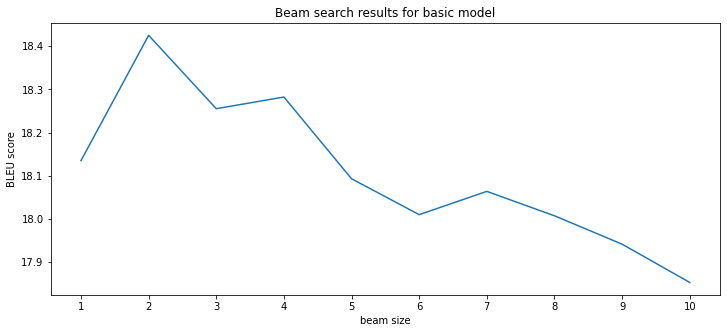

CPU times: user 15min 59s, sys: 9.12 s, total: 16min 8s
Wall time: 16min 15s


In [22]:
%time beam_research(model, dev_inp, dev_out, 'basic model')

### Basic model translations

In [23]:
for inp_line, trans_line, out_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500], device=device, beam_size=2)[0], dev_out[::500]):
    print(f'input line: {inp_line}')
    print(f'translated line: {trans_line}')
    print(f'target line: {out_line}')
    print()

input line: в распоряжении гостей общая кухня и общая гостиная .
translated line: you will find a shared kitchen and a shared kitchen .
target line: a shared equipped kitchen and a common living room are provided to guests .

input line: кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
translated line: the property offers free parking and bike hire .
target line: bicycle rental and shuttle services are also available . the property offers free parking .

input line: расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
translated line: lake trasimeno is 17 km away .
target line: the unit is 26 km from kissimmee .

input line: апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
translated line: located in a residential area , this apartment features a swimming pool and a sun terrace . the property is a 2 - minute walk from the b

# Attention layer

Given encoder sequence $ h^e_0, h^e_1, h^e_2, ..., h^e_T$ and a single decoder state $h^d$,

* Compute logits with a 2-layer neural network
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Get probabilities from logits, 
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Add up encoder states with probabilities to get __attention response__
$$ attn = \sum_t p_t \cdot h^e_t $$

You can learn more about attention layers in the lecture slides or [from this post](https://distill.pub/2016/augmented-rnns/).

### Seq2seq model with attention

The simplest way to implement attention is to use it in decoder phase:
![img](https://i.imgur.com/6fKHlHb.png)
_image from distill.pub [article](https://distill.pub/2016/augmented-rnns/)_

On every step, use __previous__ decoder state to obtain attention response. Then feed concat this response to the inputs of next attention layer.

The key implementation detail here is __model state__. Put simply, you can add any tensor into the list of `encode` outputs. You will then have access to them at each `decode` step. This may include:
* Last RNN hidden states (as in basic model)
* The whole sequence of encoder outputs (to attend to) and mask
* Attention probabilities (to visualize)

_There are, of course, alternative ways to wire attention into your network and different kinds of attention. Take a look at [this](https://arxiv.org/abs/1609.08144), [this](https://arxiv.org/abs/1706.03762) and [this](https://arxiv.org/abs/1808.03867) for ideas. And for image captioning/im2latex there's [visual attention](https://arxiv.org/abs/1502.03044)_

In [24]:
from models import AttentiveModel

### Training attentive model

Reusing the structure we've built for the regular model.

In [25]:
from IPython.display import clear_output
from tqdm import tqdm, trange
metrics = {'train_loss': [], 'dev_bleu': [] }

model = AttentiveModel(inp_voc, out_voc).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

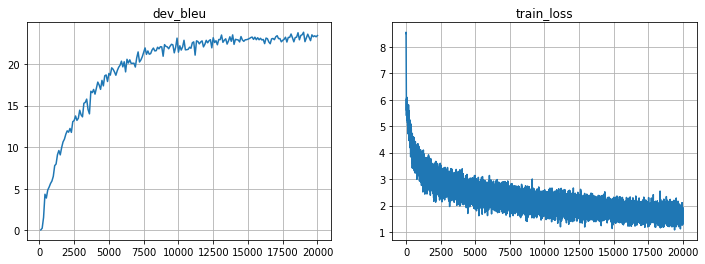

Mean loss=1.590


100%|██████████| 20000/20000 [52:24<00:00,  6.36it/s]


In [26]:
metrics = train_loop(
    model,
    optimizer, 
    train_inp, 
    num_epochs=20000,
    from_checkpoint=False
)

In [27]:
best_checkpoint = torch.load('/content/best_bleu_state.pth')
print('best BLEU = ', best_checkpoint['bleu'])
print('best epoch = ', best_checkpoint['epoch'])

print('Mean BLEU on last 10 epoches = ', np.mean(metrics['dev_bleu'][-10:], axis=0)[1]) # Attentive model BLEU

best BLEU =  23.800021740891825
best epoch =  19000
Mean BLEU on last 10 epoches =  23.208725784068157


### Beam research (attentive model)

In [28]:
# Return to best checkpoint

print("=> Loading checkpoint")
model.load_state_dict(best_checkpoint["state_dict"])
optimizer.load_state_dict(best_checkpoint["optimizer"])

=> Loading checkpoint


In [30]:
%time beam_research(model, dev_inp, dev_out, 'Attentive model')

ValueError: ignored

### Attentive model translations

In [31]:
for inp_line, trans_line, out_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500], device='cuda')[0], dev_out[::500]):
    print(f'input line: {inp_line}')
    print(f'translated line: {trans_line}')
    print(f'target line: {out_line}')
    print()

input line: в распоряжении гостей общая кухня и общая гостиная .
translated line: guests can use a shared kitchen and a shared lounge .
target line: a shared equipped kitchen and a common living room are provided to guests .

input line: кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
translated line: bicycle rental service and shuttle service are available .
target line: bicycle rental and shuttle services are also available . the property offers free parking .

input line: расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
translated line: p@@ burn is 18 km away .
target line: the unit is 26 km from kissimmee .

input line: апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
translated line: located in a beach , a 5 - minute walk from the beach , this guest house features a garden , garden and terrace .
target line: situa

__My comment:__   
As we can see, the translation is way better now.  
Our model also translated the line __'составляет 26 км' --> 'is 26 km from property'__ correctly.

### Visualizing model attention 

After training the attentive translation model, you can check it's sanity by visualizing its attention weights.

We provided you with a function that draws attention maps using [`Bokeh`](https://bokeh.pydata.org/en/latest/index.html). Once you managed to produce something better than random noise, please save at least 3 attention maps and __submit them to anytask__ alongside this notebook to get the max grade. Saving bokeh figures as __cell outputs is not enough!__ (TAs can't see saved bokeh figures in anytask). You can save bokeh images as screenshots or using this button:

![bokeh_panel](https://github.com/yandexdataschool/nlp_course/raw/2019/resources/bokeh_panel.png)

__Note:__ you're not locked into using bokeh. If you prefer a different visualization method, feel free to use that instead of bokeh.

In [ ]:
import bokeh.plotting as pl
import bokeh.models as bm
from bokeh.io import output_notebook, show
output_notebook()

def draw_attention(inp_line, translation, probs):
    """ An intentionally ambiguous function to visualize attention weights """
    inp_tokens = inp_voc.tokenize(inp_line)
    trans_tokens = out_voc.tokenize(translation)
    probs = probs[:len(trans_tokens), :len(inp_tokens)]
    
    fig = pl.figure(x_range=(0, len(inp_tokens)), y_range=(0, len(trans_tokens)),
                    x_axis_type=None, y_axis_type=None, tools=[])
    fig.image([probs[::-1]], 0, 0, len(inp_tokens), len(trans_tokens))

    fig.add_layout(bm.LinearAxis(axis_label='source tokens'), 'above')
    fig.xaxis.ticker = np.arange(len(inp_tokens)) + 0.5
    fig.xaxis.major_label_overrides = dict(zip(np.arange(len(inp_tokens)) + 0.5, inp_tokens))
    fig.xaxis.major_label_orientation = 45

    fig.add_layout(bm.LinearAxis(axis_label='translation tokens'), 'left')
    fig.yaxis.ticker = np.arange(len(trans_tokens)) + 0.5
    fig.yaxis.major_label_overrides = dict(zip(np.arange(len(trans_tokens)) + 0.5, trans_tokens[::-1]))

    show(fig)

In [ ]:
inp = dev_inp[::500]

trans, states = model.translate_lines(inp)

print(states.size())
# select attention probs from model state (you may need to change this for your custom model)
# attention_probs below must have shape [batch_size, translation_length, input_length], extracted from states
# e.g. if attention probs are at the end of each state, use np.stack([state[-1] for state in states], axis=1)
attention_probs = <YOUR CODE>

In [ ]:
for i in range(5):
    draw_attention(inp[i], trans[i], attention_probs[i])
    
# Does it look fine already? don't forget to save images for anytask!

__Note 1:__ If the attention maps are not iterpretable, try starting encoder from zeros (instead of dec_start), forcing model to use attention.

__Note 2:__ If you're studying this course as a YSDA student, please submit __attention screenshots__ alongside your notebook.

## Goind deeper (2++ points each)

We want you to find the best model for the task. Use everything you know.

* different recurrent units: rnn/gru/lstm; deeper architectures
* bidirectional encoder, different attention methods for decoder (additive, dot-product, multi-head)
* word dropout, training schedules, anything you can imagine
* replace greedy inference with beam search

For a better grasp of seq2seq We recommend you to conduct at least one experiment from one of the bullet-points or your alternative ideas. As usual, describe what you tried and what results you obtained in a short report.

`[your report/log here or anywhere you please]`